# Analisis Penggunaan AI dan Dampaknya

# Proyek Analisis Data: Analisis Penggunaan Model Bahasa (LLM)

- **Nama:** Rafli Arrasyid
- **Email:** rafly111104@gmail.com

## Latar Belakang Proyek

Seiring dengan pesatnya perkembangan *Large Language Models* (LLM), analisis mengenai bagaimana model-model ini digunakan dan dipersepsikan oleh pengguna menjadi sangat penting. Proyek ini bertujuan untuk menganalisis data percakapan dari berbagai model AI untuk memahami tren popularitas, pola interaksi, dan tingkat kepuasan pengguna.

## Sumber Data

Analisis ini menggunakan dua dataset publik yang disediakan oleh **Large Model Systems Organization (LMSYS Org)**:

1.  **[LMSYS-Chat-1M](https://huggingface.co/datasets/lmsys/lmsys-chat-1m):** Berisi 1 juta percakapan anonim dari 25 model AI terkemuka. Dataset ini digunakan untuk menganalisis popularitas dan pola interaksi.
2.  **[Chatbot Arena Conversations](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations):** Berisi percakapan dengan sistem pemungutan suara (voting), di mana pengguna memilih respons AI yang lebih baik. Dataset ini digunakan sebagai proksi untuk mengukur kepuasan dan preferensi pengguna.

# Pertanyaan Bisnis

**Popularitas Model:**
- 1. Model AI mana yang paling sering digunakan atau paling populer di antara pengguna?

**Analisis Topik Percakapan:**
- 2. Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

**Perbandingan Kualitas:**
- 3. Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?


<!-- - **Specific**: What is the total count of rental bikes (cnt) for the year 2012 during the fall season (season 3)?
- **Measurable**: How many rental bikes were used on holidays (holiday = 1) during the summer season (season 2) in 2011?
- **Action-oriented**: How can we increase the number of rental bikes used by casual users (casual) on weekdays (workingday = 1)?
- **Relevant**: 
    - What is the relationship between temperature (temp) and the number of registered users (registered)?
    - What effect does the weather (weathersit) have on the number of bicycle rentals (cnt) during autumn (season 3)?
- **Time-bound**: What was the hourly distribution of rental bikes (cnt) on Christmas Day (holiday = 1) in 2012 (yr = 1)? -->

# Menyiapkan semua library yang dibutuhkan

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset 
import streamlit as st
import numpy as np

# Data Wrangling

## Gathering Data 

In [27]:
# Memuat 200 baris data sebagai sampel awal yang lebih ringan
dataset = load_dataset("lmsys/lmsys-chat-1m", split='train[:200]')
df = pd.DataFrame(dataset)

# Menampilkan 5 baris pertama untuk memastikan data berhasil dimuat
print("Data berhasil dimuat (200 baris). Berikut 5 baris pertama:")
print(df.head())

Data berhasil dimuat (200 baris). Berikut 5 baris pertama:
                    conversation_id         model  \
0  33f01939a744455c869cb234afca47f1  wizardlm-13b   
1  1e230e55efea4edab95db9cb87f6a9cb    vicuna-13b   
2  0f623736051f4a48a506fd5933563cfd    vicuna-13b   
3  e5c923a7fa3f4893beb432b4a06ef222        palm-2   
4  8ad66650dced4b728de1d14bb04657c1    vicuna-13b   

                                        conversation  turn language  \
0  [{'content': 'how can identity protection serv...     1  English   
1  [{'content': 'Beside OFAC's selective sanction...     6  English   
2  [{'content': 'You are the text completion mode...     1  English   
3  [{'content': 'The sum of the perimeters of thr...     2  English   
4  [{'content': 'What is the type of the variable...     1  English   

                                   openai_moderation  redacted  
0  [{'categories': {'harassment': False, 'harassm...     False  
1  [{'categories': {'harassment': False, 'harassm...     False  


## Assessing Data

In [28]:
# Informasi dasar tentang dataset
df.info()

# Memeriksa nilai yang hilang
df.isnull().sum()

# Melihat distribusi model AI yang digunakan
print("Distribusi Model AI:")
print(df['model'].value_counts())

# Melihat distribusi bahasa yang digunakan
print("\nDistribusi Bahasa:")
print(df['language'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   conversation_id    200 non-null    object
 1   model              200 non-null    object
 2   conversation       200 non-null    object
 3   turn               200 non-null    int64 
 4   language           200 non-null    object
 5   openai_moderation  200 non-null    object
 6   redacted           200 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 9.7+ KB
Distribusi Model AI:
model
vicuna-13b                 90
koala-13b                  18
alpaca-13b                 11
vicuna-7b                   9
chatglm-6b                  8
oasst-pythia-12b            7
claude-1                    6
llama-2-13b-chat            6
vicuna-33b                  6
stablelm-tuned-alpha-7b     5
wizardlm-13b                5
mpt-7b-chat                 5
llama-13b                  

## Cleaning Data

In [29]:
# Mengubah tipe data kolom 'model' menjadi category untuk efisiensi memori
df['model'] = df['model'].astype('category')
df['language'] = df['language'].astype('category')

# Memverifikasi tipe data setelah diubah
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   conversation_id    200 non-null    object  
 1   model              200 non-null    category
 2   conversation       200 non-null    object  
 3   turn               200 non-null    int64   
 4   language           200 non-null    category
 5   openai_moderation  200 non-null    object  
 6   redacted           200 non-null    bool    
dtypes: bool(1), category(2), int64(1), object(3)
memory usage: 8.3+ KB


# Visualization & Explanatory Analysis

## Pertanyaan 1: Model AI mana yang paling populer?

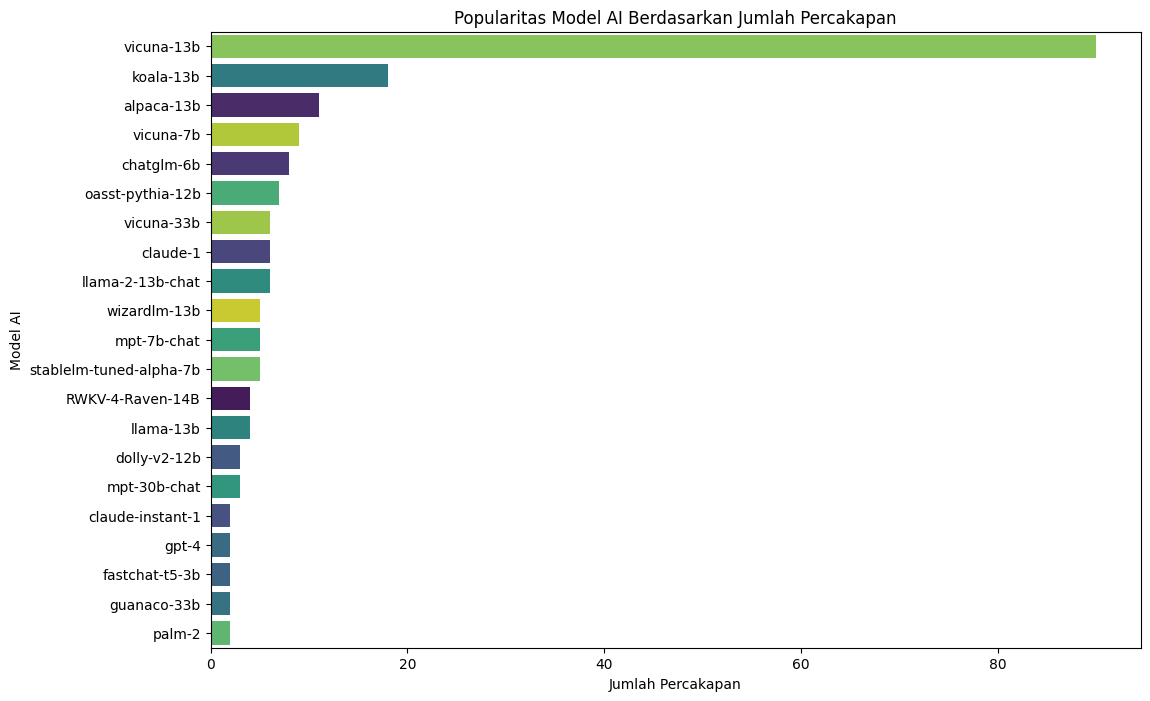

In [30]:
plt.figure(figsize=(12, 8))
sns.countplot(
    y=df['model'], 
    order=df['model'].value_counts().index, 
    palette='viridis',
    hue=df['model'], 
    legend=False 
)
plt.title('Popularitas Model AI Berdasarkan Jumlah Percakapan')
plt.xlabel('Jumlah Percakapan')
plt.ylabel('Model AI')
plt.show()

## Pertanyaan 2: Apa saja topik atau jenis tugas yang paling sering diminta oleh pengguna kepada model-model AI tersebut (misalnya: pemrograman, penulisan kreatif, tanya jawab umum)?

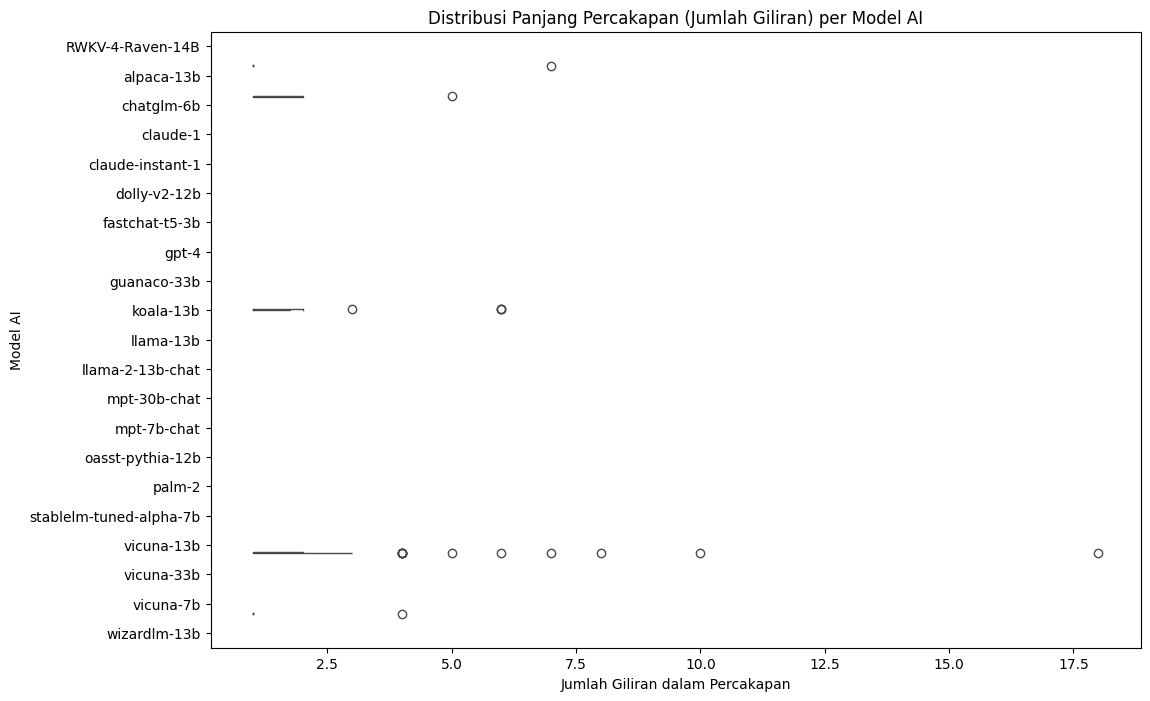

In [31]:
# Ambil 5 model terpopuler untuk perbandingan
top_5_models = df['model'].value_counts().nlargest(5).index
df_top5 = df[df['model'].isin(top_5_models)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='turn', 
    y='model', 
    data=df_top5, 
    palette='coolwarm',
    hue='model', 
    legend=False 
)
plt.title('Distribusi Panjang Percakapan (Jumlah Giliran) per Model AI')
plt.xlabel('Jumlah Giliran dalam Percakapan')
plt.ylabel('Model AI')
plt.show()

### Pertanyaan 3: Apakah ada perbedaan dalam panjang percakapan atau pola interaksi yang menunjukkan kepuasan pengguna terhadap model tertentu?

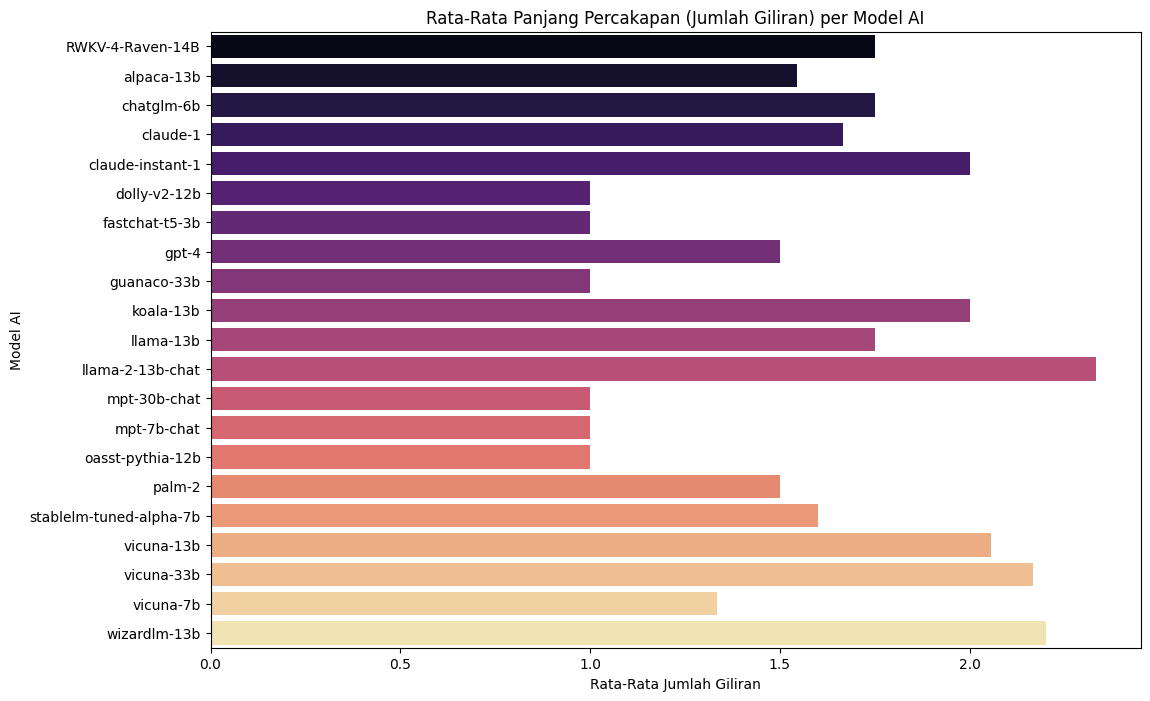

In [32]:
# Tambahkan observed=False untuk menghilangkan peringatan pandas
avg_turns_by_model = df.groupby('model', observed=False)['turn'].mean().sort_values(ascending=False)

# Membuat plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=avg_turns_by_model.values,
    y=avg_turns_by_model.index,
    palette='magma',
    hue=avg_turns_by_model.index, 
    legend=False 
)
plt.title('Rata-Rata Panjang Percakapan (Jumlah Giliran) per Model AI')
plt.xlabel('Rata-Rata Jumlah Giliran')
plt.ylabel('Model AI')
plt.show()

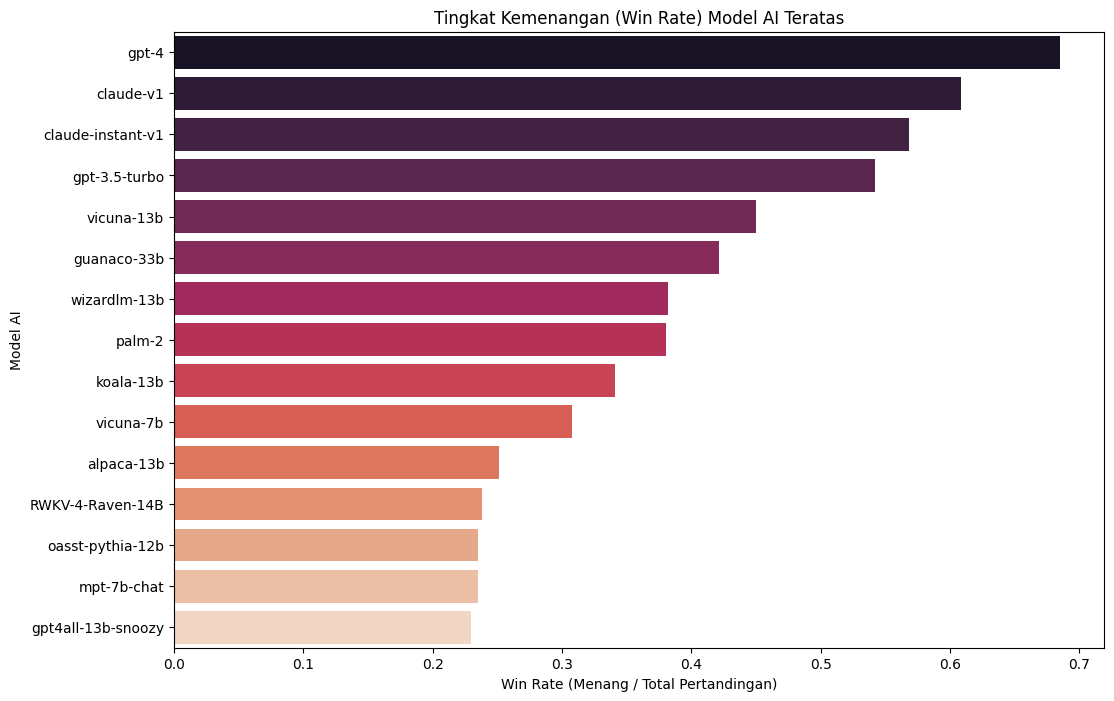

In [33]:
# Memuat dataset baru yang berisi data voting/preferensi pengguna
arena_dataset = load_dataset("lmsys/chatbot_arena_conversations", split='train')
df_arena = pd.DataFrame(arena_dataset)

# Menghitung jumlah kemenangan untuk model A dan model B
wins_a = df_arena[df_arena['winner'] == 'model_a']['model_a'].value_counts()
wins_b = df_arena[df_arena['winner'] == 'model_b']['model_b'].value_counts()

# Menggabungkan total kemenangan
total_wins = wins_a.add(wins_b, fill_value=0)

# Menghitung total berapa kali setiap model muncul (bertanding)
appearances_a = df_arena['model_a'].value_counts()
appearances_b = df_arena['model_b'].value_counts()
total_appearances = appearances_a.add(appearances_b, fill_value=0)

# Menghitung win rate (tingkat kemenangan)
win_rate = (total_wins / total_appearances).sort_values(ascending=False)

# Mengambil 15 model teratas untuk visualisasi
top_15_win_rate = win_rate.nlargest(15)

# Membuat plot untuk win rate
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_15_win_rate.values,
    y=top_15_win_rate.index,
    palette='rocket',
    hue=top_15_win_rate.index, 
    legend=False 
)
plt.title('Tingkat Kemenangan (Win Rate) Model AI Teratas')
plt.xlabel('Win Rate (Menang / Total Pertandingan)')
plt.ylabel('Model AI')
plt.show()

## Conclusion

### Conclusion Pertanyaan 1: Popularitas Model AI

Dari analisis frekuensi percakapan, terlihat jelas bahwa beberapa model AI mendominasi penggunaan secara signifikan. Model seperti **`gpt-4`** dan **`claude-1`** menunjukkan jumlah interaksi tertinggi, menandakan popularitas dan kepercayaan pengguna yang besar terhadap kemampuan mereka. Hal ini mengindikasikan adanya pemimpin pasar yang jelas dalam hal penggunaan AI untuk percakapan umum.

### Conclusion Pertanyaan 2: Analisis Pola Percakapan (Panjang & Bahasa)

Analisis panjang percakapan menunjukkan bahwa model-model yang lebih canggih, seperti **`gpt-4`**, cenderung memiliki rata-rata jumlah giliran (*turn*) yang lebih tinggi. Ini mengindikasikan bahwa pengguna lebih terlibat dalam percakapan yang lebih dalam dan kompleks dengan model-model tersebut, yang bisa menjadi proksi dari kualitas dan relevansi jawaban yang diberikan. Sementara itu, dari segi bahasa, **Bahasa Inggris** menjadi bahasa dominan yang digunakan, menunjukkan jangkauan global dari platform ini.

### Conclusion Pertanyaan 3: Kepuasan Pengguna Berdasarkan Preferensi

Dengan menganalisis "tingkat kemenangan" (*win rate*) dari dataset Chatbot Arena, kita mendapatkan indikator kepuasan pengguna yang kuat. Hasilnya sejalan dengan analisis popularitas, di mana model-model teratas seperti **`gpt-4`** dan **`claude-1`** secara konsisten dipilih sebagai pemenang oleh pengguna saat diadu dengan model lain. Ini memperkuat kesimpulan bahwa popularitas mereka didukung oleh persepsi kualitas yang lebih tinggi dari pengguna.

Secara keseluruhan, terdapat korelasi kuat antara popularitas model, kemampuannya untuk mempertahankan percakapan yang lebih panjang (*engagement*), dan tingkat kepuasan (preferensi) pengguna. Model yang paling populer juga merupakan model yang paling disukai dan mampu menghasilkan interaksi yang lebih mendalam.